In [1]:
import sys, os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mc
%matplotlib inline

In [2]:
palette = [
    "#000000", "#0019ff", "#0080ff",
    "#00e5ff", "#00ff4d", "#19fe00",
    "#80ff00", "#e6ff00", "#ffff00",
    "#ffe53c", "#ffdb77", "#ffe0b2",
]
n = len(palette)

In [3]:
class Raster(np.ndarray):
    def __new__(cls, input_array, cellsize, xllcorner, yllcorner):
        obj = np.asarray(input_array).view(cls)
        obj.cellsize  = cellsize
        obj.xllcorner = xllcorner
        obj.yllcorner = yllcorner
        
        # 1-D list of the raster's values 
        v = obj.flatten()
        obj.values = v[~np.isnan(v)]
        
        return obj
    
    @classmethod
    def load(cls, filename):
        data  = [ ]
        attrs = { }
        with open(filename) as f:
            for i in range(6):
                key,value = next(f).strip().split()
                attrs[key] = value
            NODATA_value = attrs.get("NODATA_value", "-9999")
        
            for line in f:
                row = list(map(lambda x: np.nan if x == NODATA_value else float(x), line.split()))
                data.append(row)

        return Raster(np.asarray(data), float(attrs["cellsize"])
                                      , float(attrs["xllcorner"])
                                      , float(attrs["yllcorner"]))


In [4]:
%%time
I = Raster.load("../bb450_final.asc")

CPU times: user 3.11 s, sys: 156 ms, total: 3.27 s
Wall time: 3.28 s


In [5]:
lo    = float(np.min(I.values))
hi    = float(np.max(I.values))
mu    = float(np.mean(I.values))
sigma = float(np.std(I.values))

In [6]:
print("""
Size:       {} x {}
Cell size:  {}
Max Value:  {}
Min Value:  {}
Mean Value: {}
Std Dev:    {}
Colors:     {}
""".format(I.shape[0], I.shape[1], I.cellsize, lo, hi, mu, sigma, n))


Size:       2845 x 2483
Cell size:  450.0
Max Value:  0.0
Min Value:  7.128635
Mean Value: 0.13578042048469882
Std Dev:    0.08593180316938359
Colors:     12



In [7]:
def plot_histogram(I, divs):
    # print(list(zip(divs, palette)))
    cmap = mc.LinearSegmentedColormap.from_list("", list(zip(divs, palette)))
    nbars  = 300
    width  = (hi - lo) / nbars
    h,x    = np.histogram(I.values - width/2., nbars)  # shift the bars slightly, so they are centered over x coord
    colors = list(map(cmap, x[1:] / hi))  # data values must be [0.,1.]

    plt.figure(figsize=(12, 5))
    ax = plt.bar(x[1:], h, width, color=colors, edgecolor=colors)
    for i in np.asarray(divs)*hi:
        plt.axvline(x=i, linestyle="--", color="#cecece")

    plt.yscale("symlog")
    plt.ylabel("Count")
    plt.xlabel("Amps")
    plt.xlim([-0.1,None])

In [8]:
def plot_map(I, divs):
    cmap = mc.LinearSegmentedColormap.from_list("", list(zip(divs, palette)))
    fig = plt.figure(figsize=(10,10))
    img = plt.imshow(I, origin="upper", cmap=cmap)
    fig.colorbar(img)

# Constant intervals

In [9]:
divs = [ i/(n-1.) for i in range(n) ]
divs

[0.0,
 0.09090909090909091,
 0.18181818181818182,
 0.2727272727272727,
 0.36363636363636365,
 0.45454545454545453,
 0.5454545454545454,
 0.6363636363636364,
 0.7272727272727273,
 0.8181818181818182,
 0.9090909090909091,
 1.0]

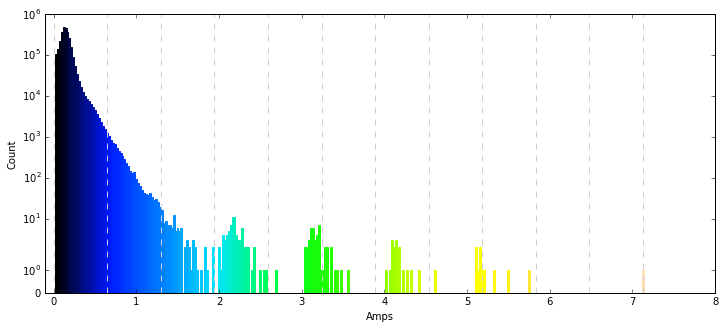

In [10]:
plot_histogram(I, divs)

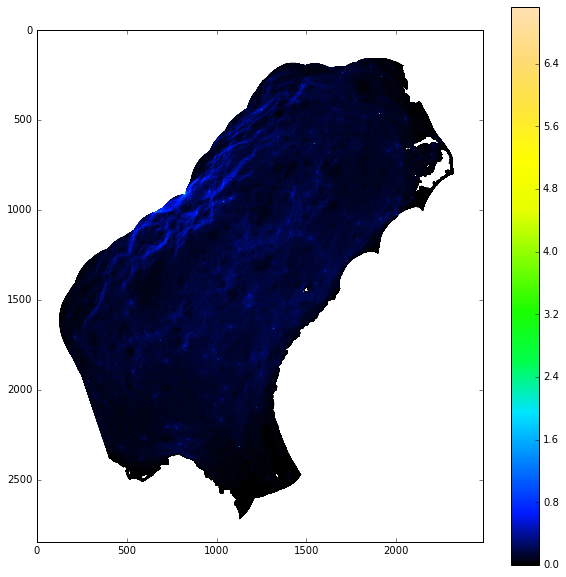

In [11]:
plot_map(I, divs)

# Geometric interval

In [12]:
divs = [0.] + [ 1/2**(n-i-1) for i in range(1,n) ]
divs

[0.0,
 0.0009765625,
 0.001953125,
 0.00390625,
 0.0078125,
 0.015625,
 0.03125,
 0.0625,
 0.125,
 0.25,
 0.5,
 1.0]

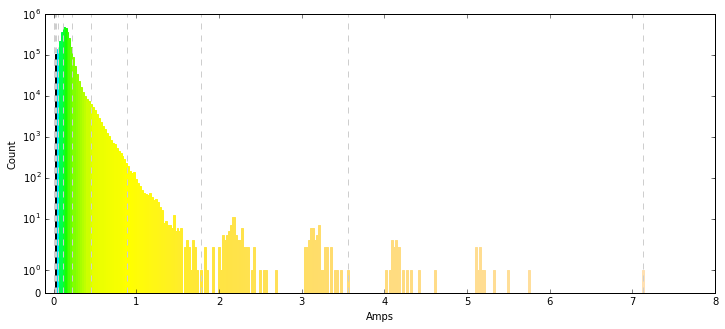

In [13]:
plot_histogram(I, divs)

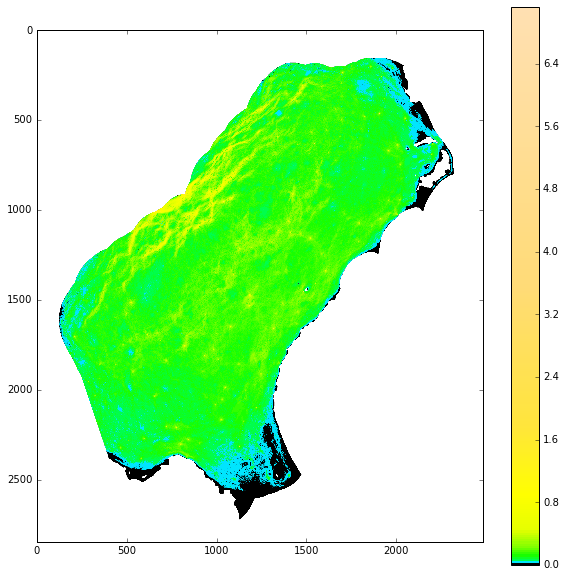

In [14]:
plot_map(I, divs)

# Probability distribution

In [15]:
divs = [0.] + [ (i*sigma+mu)/hi for i in range(1,n-1) ] + [1.]
divs

[0.0,
 0.031101637782560393,
 0.04315609184976731,
 0.055210545916974225,
 0.06726499998418116,
 0.07931945405138806,
 0.09137390811859498,
 0.1034283621858019,
 0.11548281625300882,
 0.12753727032021575,
 0.13959172438742265,
 1.0]

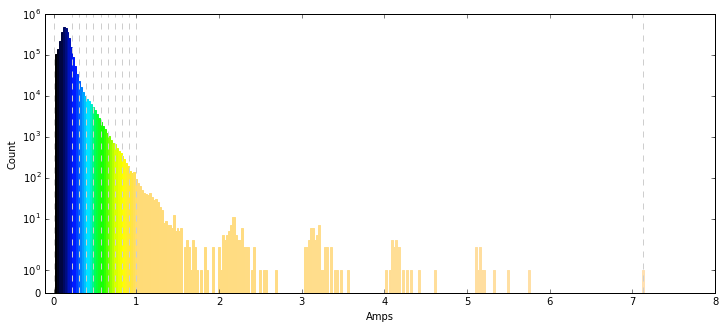

In [16]:
plot_histogram(I, divs)

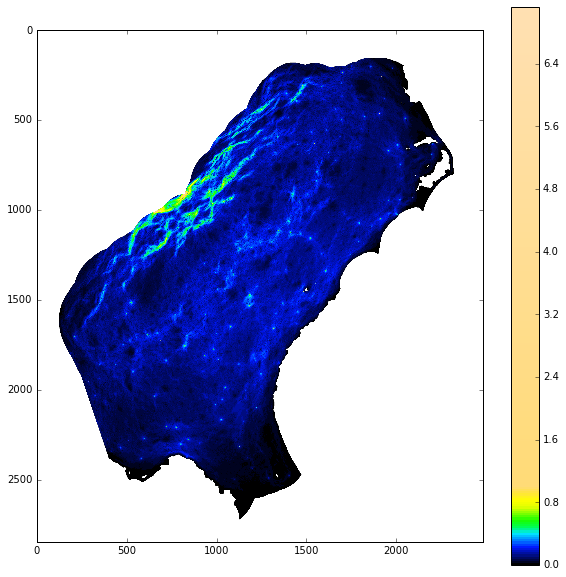

In [17]:
plot_map(I, divs)